# Proyecto de Predicción de Ventas para Productos Principales de XYZ
# Este notebook realiza una predicción de ventas utilizando un conjunto de datos filtrado para los productos que representan el 80% de las ventas.

In [1]:
# Importar librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

### Carga de Datos Limpios

Para este análisis, cargamos un conjunto de datos previamente limpiado que contiene información de ventas de productos de los años 2022, 2023 y el primer trimestre de 2024. Estos datos ya han pasado por un proceso de depuración y filtrado, eliminando registros incompletos o irrelevantes, lo que garantiza que solo utilizamos datos consistentes y de alta calidad para el modelado.

El archivo `ExporteCOL2022_2023_2024_clean.csv`, ubicado en la carpeta `silver` dentro de nuestro repositorio, representa esta versión limpia y lista para el análisis. La base de datos contiene variables clave que permitirán identificar patrones en las ventas y construir un modelo de predicción para los productos que representan el mayor volumen de ventas de la compañía, optimizando así la estrategia de negocio al enfocarnos en los productos de mayor impacto.

In [2]:
import pandas as pd

# Cargar datos limpios
file_path = '../data/silver/ExporteCOL2022_2023_2024_clean.csv'
df = pd.read_csv(file_path)
df.head()

,Año,Mes,Uen,Regional,Canal Comercial,Marquilla,Código Producto,Producto,Numérica Clientes,Numérica Documentos,Ventas Galones,Ventas,Utilidad Bruta,Costos,Margen
0,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10228936,LACA NEGRO MATE AEROCOLOR AEROSOLES 125012-801...,1,1,1.268499,129780.0,66754.53069,6.302547e+04,0.514367
1,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283186,LACA BLANCO BRILLANTE AEROCOLOR AEROSOLES 300 ML,2,11,20.919176,1605228.0,431180.39710,1.174048e+06,0.268610
2,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283187,LACA TRANSPARENTE BRILLANTE AEROCOLOR AEROSOLE...,1,1,0.950872,93600.0,40977.03571,5.262296e+04,0.437789
3,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283188,LACA NEGRO MATE AEROCOLOR AEROSOLES 300 ML,1,13,25.673534,1897920.0,419250.64040,1.478669e+06,0.220900
4,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283190,LACA ALUMINIO BRILLANTE AEROCOLOR AEROSOLES 30...,2,11,13.312203,1039068.0,239438.79160,7.996292e+05,0.230436


In [3]:
print(df.shape)

(317471, 15)


### Selección de Productos Principales Basado en Ventas

Para optimizar nuestro análisis, primero identificamos los productos que representan el 80% de las ventas totales. Este enfoque se conoce como la regla de Pareto, en la cual una parte significativa del impacto proviene de un pequeño grupo de productos.

1. **Agrupación y Suma de Ventas**:
   Calculamos la suma de ventas para cada producto agrupándolo por el `Código Producto`. Esto nos permite conocer el total de ventas de cada SKU a lo largo del tiempo.

2. **Orden de Ventas**:
   Ordenamos los productos en orden descendente de ventas para calcular el porcentaje acumulado y determinar qué productos contribuyen al 80% de las ventas totales.

3. **Filtrado de Productos**:
   Seleccionamos los productos que se encuentran dentro del umbral del 80% acumulado de ventas y creamos un nuevo DataFrame `df_principales` que contiene solo estos productos.


In [4]:
# Calcular las ventas totales por producto
ventas_por_producto = df.groupby('Código Producto')['Ventas'].sum().reset_index()

# Ordenar productos por ventas descendente
ventas_por_producto = ventas_por_producto.sort_values(by='Ventas', ascending=False)

# Calcular el porcentaje acumulado de ventas
ventas_por_producto['Porcentaje Acumulado'] = ventas_por_producto['Ventas'].cumsum() / ventas_por_producto['Ventas'].sum()

# Definir el umbral de contribución, por ejemplo, el 80% de las ventas
umbral_contribucion = 0.80

# Seleccionar solo los productos que representan el 80% de las ventas
productos_principales = ventas_por_producto[ventas_por_producto['Porcentaje Acumulado'] <= umbral_contribucion]

# Filtrar el DataFrame original para incluir solo los productos principales
df_principales = df[df['Código Producto'].isin(productos_principales['Código Producto'])]

# Verificar el tamaño del nuevo conjunto de datos
print(df_principales.shape)

(93151, 15)


### Visualización de la Distribución Acumulada de Ventas

Generamos una visualización para ilustrar el porcentaje acumulado de ventas por producto, destacando el umbral del **80%**. Esto facilita la identificación de los productos de mayor impacto.


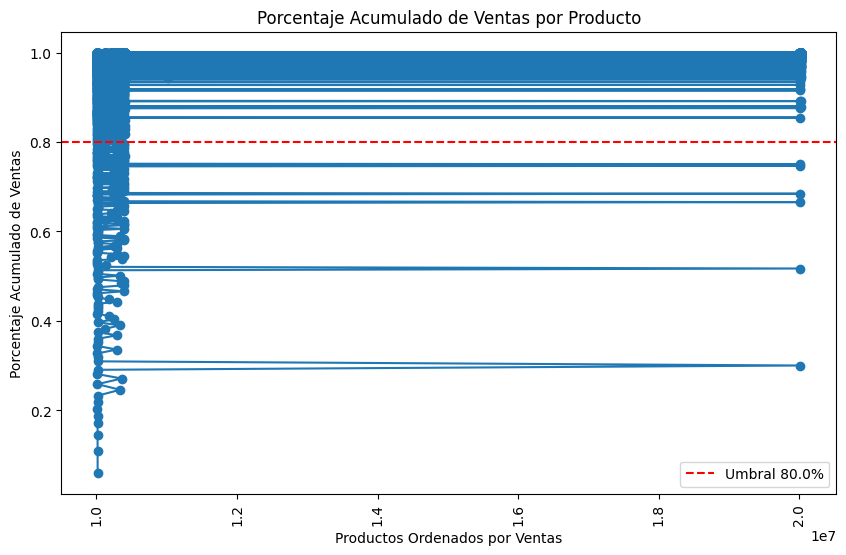

In [5]:
import matplotlib.pyplot as plt

# Visualización del porcentaje acumulado de ventas
plt.figure(figsize=(10, 6))
plt.plot(ventas_por_producto['Código Producto'], ventas_por_producto['Porcentaje Acumulado'], marker='o')
plt.axhline(y=umbral_contribucion, color='r', linestyle='--', label=f'Umbral {umbral_contribucion*100}%')
plt.title('Porcentaje Acumulado de Ventas por Producto')
plt.xlabel('Productos Ordenados por Ventas')
plt.ylabel('Porcentaje Acumulado de Ventas')
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [6]:
df_principales.head()

,Año,Mes,Uen,Regional,Canal Comercial,Marquilla,Código Producto,Producto,Numérica Clientes,Numérica Documentos,Ventas Galones,Ventas,Utilidad Bruta,Costos,Margen
1,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283186,LACA BLANCO BRILLANTE AEROCOLOR AEROSOLES 300 ML,2,11,20.919176,1605228.0,431180.3971,1.174048e+06,0.268610
3,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283188,LACA NEGRO MATE AEROCOLOR AEROSOLES 300 ML,1,13,25.673534,1897920.0,419250.6404,1.478669e+06,0.220900
14,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283224,PINTURA METALICA ORO 18 KILATES AEROCOLOR 300 ML,2,9,21.870048,2319420.0,752893.4929,1.566527e+06,0.324604
16,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283229,ALTAS TEMPERATURAS NEGRO AEROCOLOR 300 ML,1,12,13.312203,1238736.0,389584.1829,8.491518e+05,0.314501
36,2022,1,DECORATIVO,REGIONAL BARRANQUILLA,Cadenas y Grandes Superficies,AEROCOLOR,10283298,LACA NEGRO BRILLANTE AEROCOLOR AEROSOLES 300 ML,2,14,19.017433,1484748.0,371820.9796,1.112927e+06,0.250427


### Preparación de Datos para el Modelado

Para entrenar el modelo, seleccionamos variables predictoras clave (como `Año`, `Mes`, `Uen`, `Regional`, `Canal Comercial`, `Marquilla`, `Numérica Clientes`, `Numérica Documentos`) y la variable objetivo (`Ventas`). Luego dividimos el conjunto de datos en entrenamiento y prueba con una proporción 80%-20%.

In [7]:
from sklearn.model_selection import train_test_split

# Selección de las variables predictoras y la variable objetivo
X = df_principales[['Año', 'Mes', 'Uen', 'Regional', 'Canal Comercial', 'Marquilla', 'Numérica Clientes', 'Numérica Documentos']]
y = df_principales['Ventas']

# Dividir los datos en entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocesamiento y Codificación de Variables Categóricas

Para las variables categóricas (`Uen`, `Regional`, `Canal Comercial`, `Marquilla`), utilizamos un **ColumnTransformer** y **OneHotEncoder** para codificar estas variables en formato binario. Esto es esencial para que el modelo de regresión pueda interpretar las variables categóricas de manera efectiva.

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Definir columnas categóricas
categorical_features = ['Uen', 'Regional', 'Canal Comercial', 'Marquilla']

# Configurar el preprocesador para las columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Deja las columnas numéricas sin cambiar
)

## Construcción del Modelo de Regresión con RandomForest

Creamos un pipeline que incluye tanto el preprocesador como el modelo `RandomForestRegressor`. Este pipeline permite ejecutar el preprocesamiento y el entrenamiento del modelo en una sola línea de código, asegurando que las transformaciones y el modelo estén sincronizados.

In [ ]:
from sklearn.model_selection import GridSearchCV

#### PRUEBA 1 RandomForestRegressor
# # Crear el pipeline con el preprocesador y el modelo
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor(random_state=42))
# ])


#### PRUEBA 2 RandomForestRegressor CON OPTIMIZACION DE HIPERPARAMETROS
# Hiperparametros de prueba
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Creación modelo de RandomForestRegressor
rfrmodelo = RandomForestRegressor(random_state=42)

# Crear el pipeline con el preprocesador y el modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rfrmodelo)
])

# Entrenar el modelo
model.fit(X_train, y_train)


## Evaluación del Modelo

Finalmente, evaluamos el rendimiento del modelo en el conjunto de prueba utilizando métricas como el error cuadrático medio (`MSE`), el error absoluto medio (`MAE`), y el coeficiente de determinación (`R²`). Estas métricas nos ayudan a entender la precisión del modelo y su capacidad para generalizar en nuevos datos.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")


MSE: 291686836405496.9
MAE: 6036291.549243458
R2 Score: 0.6753340404843475


In [ ]:
MSE: 291686836405496.9
MAE: 6036291.549243458
R2 Score: 0.6753340404843475